In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/Shareddrives/my_workspace/uet/ImageProcessing

/content/drive/Shareddrives/my_workspace/uet/ImageProcessing


#Utils


In [3]:
def visualize(rows, cols, images, labels):
    fig = plt.figure(figsize=(10, 7))
    for i in range(len(images)):
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
        plt.title(labels[i])

In [4]:
def gaussian_discriminating_func(roi, x_nm, delta):
    output = np.zeros_like(roi, dtype="float32")
    h, w = roi.shape[:2]
    for i in np.arange(h):
        for j in np.arange(w):
             output[i][j] = math.exp(-(float(roi[i][j]) - float(x_nm))**2 / float(delta)**2)
    return output

def exponential_discriminating_func(roi, x_nm, delta):
    output = np.zeros_like(roi, dtype="float32")
    h, w = roi.shape[:2]
    for i in np.arange(h):
        for j in np.arange(w):
            output[i][j] = math.exp(-(abs(float(roi[i][j]) - float(x_nm)) / float(delta)))
    return output

In [32]:
def constrast_filter(gray):
    result = filters.unsharp_mask(gray, radius=1.5, amount=1.5, multichannel=False, preserve_range=False)
    result = (255*result).clip(0,255).astype(np.uint8)
    return result

# Robust nonlinear contrast enhancement

In [5]:
import numpy as np
import argparse
import math
import cv2

from scipy import signal
from skimage import color
import skimage.filters as filters
from matplotlib import pyplot as plt
from skimage.exposure import rescale_intensity
from google.colab.patches import cv2_imshow

In [6]:
boat = cv2.imread("boat.png")
boatGray = cv2.cvtColor(boat, cv2.COLOR_BGR2GRAY)
girl = cv2.imread("girl.png")
girlGray = cv2.cvtColor(girl, cv2.COLOR_BGR2GRAY)

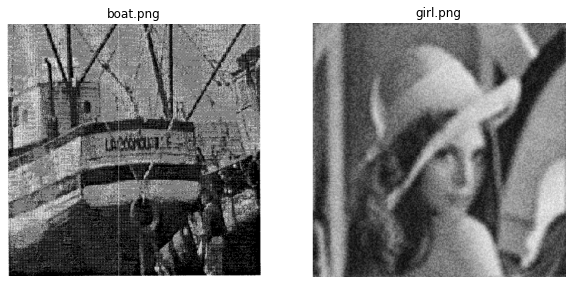

In [7]:
visualize(1, 2, [boat, girl], ['boat.png', 'girl.png'])

## Convolution

In [8]:
def convolve(image, kernel):
	# grab the spatial dimensions of the image, along with
	# the spatial dimensions of the kernel
    (iH, iW) = image.shape[:2]
    (kH, kW) = kernel.shape[:2]

	# allocate memory for the output image, taking care to
	# "pad" the borders of the input image so the spatial
	# size (i.e., width and height) are not reduced
    
    pad = (kW - 1) // 2
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
    output = np.zeros((iH, iW), dtype="float32")
 
    # loop over the input image, "sliding" the kernel across
	# each (x, y)-coordinate from left-to-right and top to bottom
    for y in np.arange(pad, iH + pad):    	
        for x in np.arange(pad, iW + pad):
            # extract the ROI of the image by extracting the
            # *center* region of the current (x, y)-coordinates
            # dimentions
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
            
            # perform the actual convolution by taking the 
            # element-wise multiplicate between the ROI and
            # the kernel, then summing the matrix
            k = (roi * kernel).sum()

            # store the convolved value in the output (x,y)-
            # coordinate of the output image
            output[y - pad, x - pad] = k
        
    
	# rescale the output image to be in the range [0, 255]
    output = rescale_intensity(output, in_range=(0, 255))
    output = (output * 255).astype("uint8")
    # return the output image
    return output


In [9]:
# construct the Laplacian kernel used to detect edge-like
# regions of an image
laplacian = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")
# construct the Sobel x-axis kernel
sobelX = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")
# construct the Sobel y-axis kernel
sobelY = np.array((
	[-1, -2, -1],
	[0, 0, 0],
	[1, 2, 1]), dtype="int")


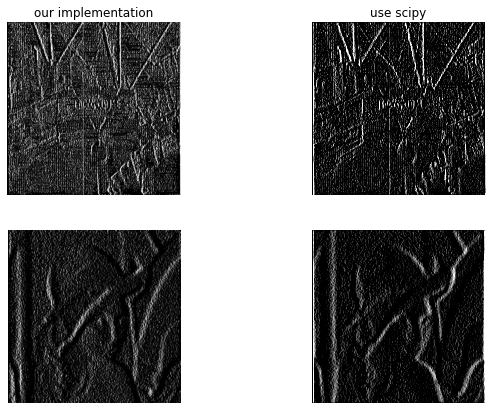

In [20]:
boat = convolve(boatGray, sobelX)
boat2 = signal.convolve2d(boatGray, sobelX)
girl = convolve(girlGray, sobelX)
girl2 = signal.convolve2d(girlGray, sobelX)
visualize(2, 2, [boat, boat2, girl, girl2], ['our implementation', 'use scipy', '', ''])

## Gradient like enhancement (GLE)

In [22]:
class GLE:
    def __init__(self, alpha=50, delta=40, get_weight=gaussian_discriminating_func):
        super().__init__()
        self.delta = delta
        self.alpha = alpha
        self.get_weight = get_weight

    def low_pass_filter(self, roi, weight):
        tmp = roi * weight
        return tmp.sum() / weight.sum() 

    def high_pass_filter(self, roi, weight):
        overline_m = weight.mean()
        delta_weight = weight - overline_m
        tmp = (weight - overline_m) * roi
        return tmp.sum()
    
    def __call__(self, image, kernel):
        (iH, iW) = image.shape[:2]
        (kH, kW) = kernel

        pad = (kW - 1) // 2
        image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
        output = np.zeros((iH, iW), dtype="float32")
        for y in np.arange(pad, iH + pad):    	        
            for x in np.arange(pad, iW + pad):
                roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
                weight = self.get_weight(roi, image[y][x], self.delta) # m_{i,j}
                y_L = self.low_pass_filter(roi, weight)
                y_H = self.high_pass_filter(roi, weight)
                output[y - pad][x - pad] = y_L + (y_L * y_H / self.alpha)

        # rescale the output image to be in the range [0, 255]
        output = rescale_intensity(output, in_range=(0, 255))
        output = (output * 255).astype("uint8")
        # return the output image
        return output

## Laplacian like enhancement (LLE)

In [23]:
class LLE:
    def __init__(self, alpha=50, delta=40, get_weight=gaussian_discriminating_func):
        super().__init__()
        self.delta = delta
        self.alpha = alpha
        self.get_weight = get_weight

    def low_pass_filter(self, roi, weight):
        tmp = roi * weight
        return tmp.sum() / weight.sum() 

    def high_pass_filter(self, roi, weight, x_nm):
        overline_m = weight.mean()
        # delta_weight = weight - overline_m
        tmp = (abs(weight - overline_m) * x_nm).sum() - (abs(weight - overline_m) * roi).sum()
        return tmp
    
    def __call__(self, image, kernel):
        (iH, iW) = image.shape[:2]
        (kH, kW) = kernel

        pad = (kW - 1) // 2
        image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
        output = np.zeros((iH, iW), dtype="float32")
        for y in np.arange(pad, iH + pad):    	        
            for x in np.arange(pad, iW + pad):
                roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
                weight = self.get_weight(roi, image[y][x], self.delta) # m_{i,j}
                y_L = self.low_pass_filter(roi, weight)
                y_H = self.high_pass_filter(roi, weight, image[y][x])
                output[y - pad][x - pad] = y_L + (y_L * y_H / self.alpha)

        # rescale the output image to be in the range [0, 255]
        output = rescale_intensity(output, in_range=(0, 255))
        output = (output * 255).astype("uint8")
        # return the output image
        return output

#Visualization

In [45]:
gle_filter = GLE()
lle_filter = LLE()

## Compare with skimage.filters.unsharp_mask

In [47]:
ski_boat = constrast_filter(boatGray)
gle_boat = gle_filter(boatGray, (3, 3))
lle_boat = gle_filter(boatGray, (3, 3))

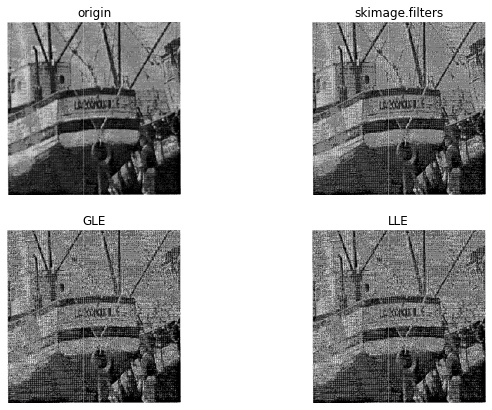

In [44]:
visualize(2, 2, [boatGray, ski_boat, gle_boat, lle_boat], ['origin', 'skimage.filters', 'GLE', 'LLE'])

In [46]:
ski_girl = constrast_filter(girlGray)
gle_girl = gle_filter(girlGray, (3, 3))
lle_girl = gle_filter(girlGray, (3, 3))

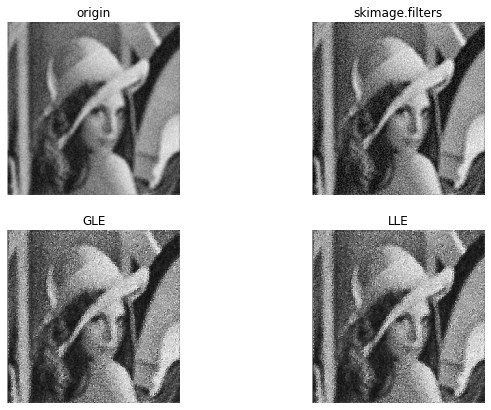

In [41]:
visualize(2, 2, [girlGray, ski_girl, gle_girl, lle_girl], ['origin', 'skimage.filters', 'GLE', 'LLE'])

## Using serveral type of kernel sizes

In [49]:
gle_boat3x3 = gle_filter(boatGray, (3, 3))
gle_boat5x5 = gle_filter(boatGray, (5, 5))
gle_boat7x7 = gle_filter(boatGray, (7, 7))
gle_girl3x3 = gle_filter(girlGray, (3, 3))
gle_girl5x5 = gle_filter(girlGray, (5, 5))
gle_girl7x7 = gle_filter(girlGray, (7, 7))

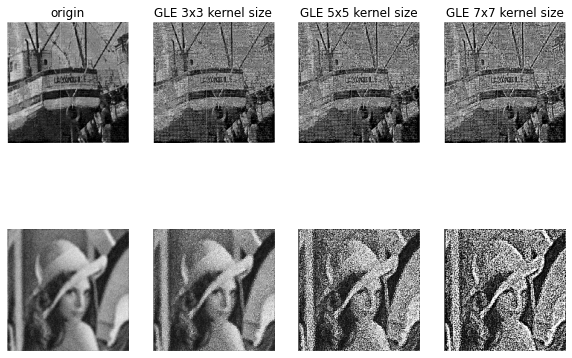

In [52]:
visualize(2, 4, [boatGray, gle_boat3x3, gle_boat5x5, gle_boat7x7, girlGray, gle_girl3x3, gle_girl5x5, gle_girl7x7], ['origin', 'GLE 3x3 kernel size', 'GLE 5x5 kernel size', 'GLE 7x7 kernel size', '', '', '', ''])

In [53]:
lle_boat3x3 = lle_filter(boatGray, (3, 3))
lle_boat5x5 = lle_filter(boatGray, (5, 5))
lle_boat7x7 = lle_filter(boatGray, (7, 7))
lle_girl3x3 = lle_filter(girlGray, (3, 3))
lle_girl5x5 = lle_filter(girlGray, (5, 5))
lle_girl7x7 = lle_filter(girlGray, (7, 7))

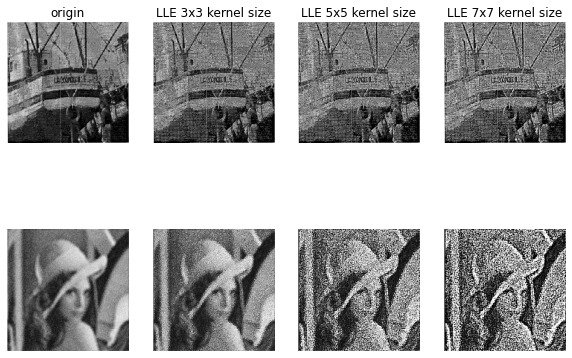

In [54]:
visualize(2, 4, [boatGray, lle_boat3x3, lle_boat5x5, lle_boat7x7, girlGray, lle_girl3x3, lle_girl5x5, lle_girl7x7], ['origin', 'LLE 3x3 kernel size', 'LLE 5x5 kernel size', 'LLE 7x7 kernel size', '', '', '', ''])